# Forward model corner plot

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
### Full version working
import pdb, sys, os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import sys
import utils
import itertools

from pylab import *
from netCDF4 import *

# import pyexcel
import scipy.stats as stats
from scipy.interpolate import griddata
from matplotlib.ticker import AutoMinorLocator

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = utils.plot_params()
plt.rcParams.update(params)

import glob

## Load

In [68]:
base_dir = "data/tspec_forward_model_corner"
target = "HAT-P-23"
data_dict = {
    # Matrix of chisq values: N_models x N_iterations?
    "chisq": np.loadtxt(f"{base_dir}/{target}_iso_chi_square_local_GAIA_DR2.out", delimiter=','),
    "offset":      np.loadtxt(f"{base_dir}/{target}_iso_offsetarray_local_GAIA_DR2.out", delimiter=','),
    # Corresponding matrix of parameter values: N_models x N_params
    "model_params":  np.genfromtxt(
        f"{base_dir}/{target}_iso_model_name_local_GAIA_DR2.out",
        delimiter = '_',
        usecols = range(1, 7),
        names = ["Temperature", "Gravity", "Metallicity", r"C/O-ratio", "Haze", "Clouds"],
        deletechars='',
    ),
}

## Compute

In [69]:
chi_squared_stat3 = data_dict["chisq"]
min_chi3 = np.min(chi_squared_stat3)
min_coords = np.argwhere(chi_squared_stat3 == min_chi3)[0]
min_index_chi3 = min_coords[0]
min_index_chi3_offset = min_coords[1]

In [70]:
# Minimum chisq Model Parameters: (temp, gravity, metal, co, haze, cloud)
model_params = data_dict["model_params"]
min_model_params = model_params[min_index_chi3]

In [72]:
param_ranges = {
    "Temperature": np.arange(400, 2700, 100.0),
    "Gravity": np.array([20, 50.0]),
    "Metallicity": np.array([-1, 0, 1, 1.7, 2, 2.3]),
    "C/O-ratio": np.array([0.35, 0.56, 0.70, 1]),
    "Haze": np.array([1, 10, 150, 1100.0]) ,
    "Clouds": np.array([0, 0.06, 0.2, 1]), # Cloud bottom
}

def match_params(
    params_ranges,
    variablex,
    variabley,
    i,
    j,
    params=model_params,
    chi_vals=chi_squared_stat3,
    min_chi=min_chi3,
):
    # Select parameter pair to search for
    param_val_1, param_val_2 = param_ranges[variablex][i], param_ranges[variabley][j]
    
    # Match to chi_squared array
    #print(f"Trying match for ({variablex}, {variabley}) at ({param_val_1}, {param_val_2})")
    #print(params[variablex], params[variabley])
    params_match = np.where((params[variablex] == param_val_1) & (params[variabley] == param_val_2))[0]
    
    if params_match.size == 0:
        #print("No match\n")
        return -1

    # Compute 
    chi1 = np.min(chi_vals[params_match], axis=1)
    chi2 = np.min(chi1) - min_chi3
    mapname = [param_val_1, param_val_2, chi2]
    #print("Match!\n")
    return mapname


map_dict = {}
for param_x, param_y in itertools.combinations(param_ranges.items(), 2):
    param_x_name, param_y_name = param_x[0], param_y[0]
    param_x_length, param_y_length = len(param_x[1]), len(param_y[1])
    map_vals = np.array([
        match_params(param_ranges, param_x_name, param_y_name, i, j)
        for i in range(param_x_length) for j in range(param_y_length)
    ])
    
    map_dict[f"{param_x_name}_{param_y_name}"] = map_vals
    
#        x = [match_params(param_ranges, "Temperature", "Gravity", i, j) for i in range(3) for j in range(3)]
#match_params(param_ranges, "Temperature", "Gravity", 2, 0)

In [ ]:
def plot_contour_map(ax, mapname):
    map_variable_x = mapname[:, 0]  # temp_metal_matrix[:,1]
    map_variable_y = mapname[:, 1]
    xi = np.linspace(min(map_variable_x), max(map_variable_x), 100)
    yi = np.linspace(min(map_variable_y), max(map_variable_y), 100)

    Z_interp = griddata(
        (map_variable_x, map_variable_y),
        mapname[:, 2],
        (xi[None, :], yi[:, None]),
    )

    # levels = [25, 30, 35, 40, 45]
    # levels = [0, 2.30, 3.22, 4.61, 5.99, 6.18, 9.21, 11.83, 13.82, 19.33]
    levels = [
        0,
        2.30,
        6.18,
        11.83,
        19.33,
    ]  # How many free parameters were used to calculate these intervals from the big chisquare table

    line2 = ax.contourf(
        xi, yi, Z_interp, levels, cmap="afmhot", vmin=0, vmax=30
    )  ### vmax has been changed from 19.33 to 25 to make end darker

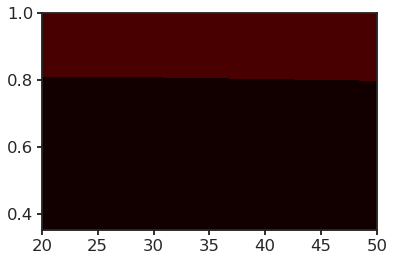

In [75]:
fig, ax = plt.subplots()
mapname = map_dict["Gravity_C/O-ratio"]
plot_contour_map(ax, mapname)